In [42]:
# Import Libraries
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Read the data

df = pd.read_csv("pollution_us_2000_2016.csv")
print("Data Ingested")
# Time  data Formatting
df = df.drop(['Unnamed: 0'], axis=1)
df['Date Local'] = pd.to_datetime(df['Date Local'],format='%Y-%m-%d') # date parse
df['Year'] = df['Date Local'].dt.year # year

Data Ingested


In [43]:
def custom_describe(df):
    """
    AQI
    """
    unique_count = []
    for x in df.columns:
        mode = df[x].mode().iloc[0]
        unique_count.append([x,
                             len(df[x].unique()),
                             df[x].isnull().sum(),
                             mode,
                             df[x][df[x]==mode].count(),
                             df[x].dtypes])
    print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
    return pd.DataFrame(unique_count, columns=["Column","Unique","Missing","Mode","Mode Occurence","dtype"]).set_index("Column").T
describe = custom_describe(df)
display(describe.iloc[:,0:15])
display(describe.iloc[:,15:])

Dataframe Dimension: 1746661 Rows, 29 Columns


Column,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean
Unique,47,73,110,204,47,133,144,5996,1,31859,990,24,129,1,8196
Missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mode,6,13,5,PIKE AVE AT RIVER ROAD,California,Los Angeles,Not in a city,2002-06-10 00:00:00,Parts per billion,0,20,6,25,Parts per million,0.026
Mode Occurence,576142,149210,76108,35332,576142,93381,138411,640,1746661,8244,31394,168945,77270,1746661,2630
dtype,int64,int64,int64,object,object,object,object,datetime64[ns],object,float64,float64,int64,int64,object,float64


Column,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Year
Unique,134,24,125,1,12736,921,24,141,1,34123,2698,24,108,17
Missing,0,0,0,0,0,0,0,872907,0,0,0,0,873323,0
Mode,0.034,10,31,Parts per billion,0,1,8,0,Parts per million,0.2,0.3,0,3,2013
Mode Occurence,48910,479532,98171,1746661,146207,173571,235677,191914,1746661,62953,220519,544131,145929,134576
dtype,float64,int64,int64,object,float64,float64,int64,float64,object,float64,float64,int64,float64,int64


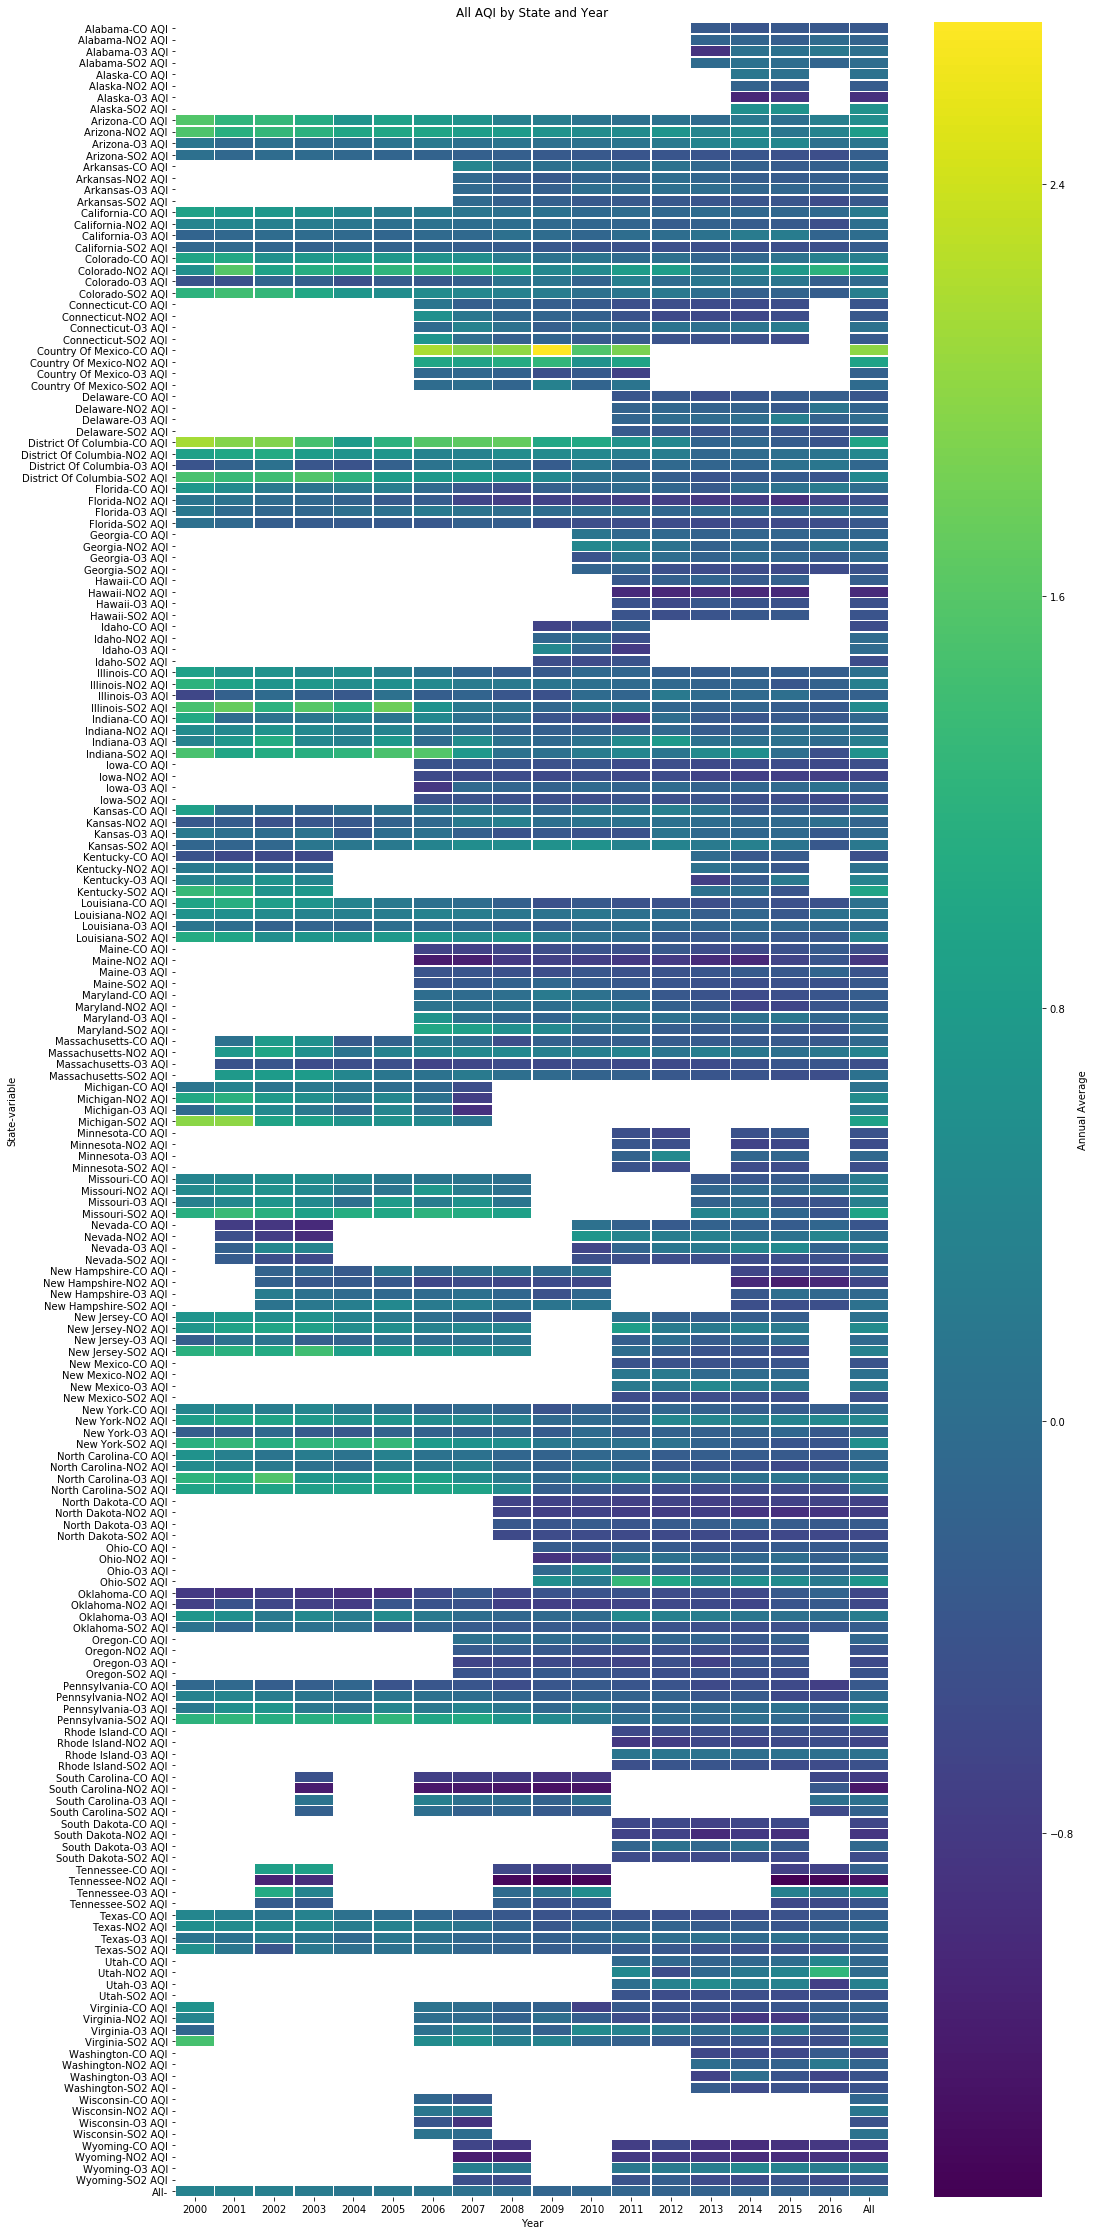

In [56]:
polldata= ['NO2 AQI','O3 AQI','SO2 AQI',"CO AQI"]
stack_df = df[['State','Year','NO2 AQI','O3 AQI','SO2 AQI',"CO AQI"]]

for col in polldata:
    stack_df[col] =(stack_df[col] - stack_df[col].mean())/stack_df[col].std(ddof=0)
    
stack_df = stack_df.melt(["State", "Year"])#.stack()
stack_df.head()

# Create Heatmap Pivot with State as Row, Year as Col, So2 as Value
polldata= ['NO2 AQI','O3 AQI','SO2 AQI',"CO AQI"]

f, ax = plt.subplots(figsize=(16,40))
ax.set_title('All AQI by State and Year')
sns.heatmap(stack_df.pivot_table(values="value", index=["State", "variable"], columns=["Year"], aggfunc='mean',margins=True),
                annot=False, linewidths=.5, ax=ax,cbar_kws={'label': 'Annual Average'}, cmap="viridis")
plt.show()

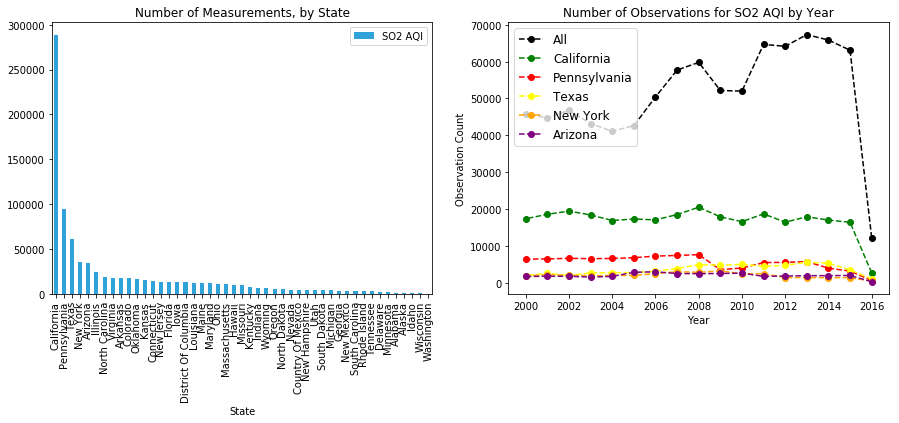

In [54]:
f , ax = plt.subplots(1,2, figsize=[15,5])
df[['SO2 AQI','State']].groupby(["State"]).count()\
.sort_values(by='SO2 AQI',ascending=False).plot.bar(ax=ax[0])
ax[0].set_title("Number of Measurements, by State")

var = "SO2 AQI"

# Df
temp_df = df[[var,'Year','State']].groupby(["Year"]).count().reset_index().sort_values(by='Year',ascending=False)
topstate = df[[var,'State']].groupby(["State"]).count().sort_values(by='SO2 AQI',ascending=False).index [:5]
state_col = ["green","red","yellow","orange","purple"]

# Plot
ax[1].set_title('Number of Observations for {} by Year'.format(var))
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Observation Count')
plt.plot(temp_df.Year,temp_df["SO2 AQI"],marker='o', linestyle='--', color='black', label='Square')
for (i,col) in zip(topstate, state_col):
    state_df= df[df.State==i][[var,'Year','State']].groupby(["Year"])\
    .count().reset_index().sort_values(by='Year',ascending=False)
    ax[1].plot(state_df.Year,state_df[var],marker='o', linestyle='--', color=col, label='Square')
ax[1].legend(topstate.insert(0, "All") , loc=2,fontsize='large')
plt.show()

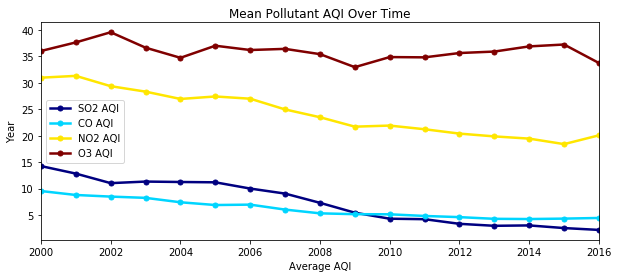

In [45]:
# Plot the aggregate decrease of all pollutants
f, ax = plt.subplots(figsize=[10,4])
df.groupby(['Year']).agg({'SO2 AQI': 'mean',
                          'CO AQI': 'mean',
                          'NO2 AQI': 'mean',
                          'O3 AQI': 'mean'})\
.plot(lw=2,colormap='jet',marker='.',markersize=10, ax =ax,linewidth=2.5)
ax.set_title('Mean Pollutant AQI Over Time')
ax.set(xlabel="Average AQI", ylabel="Year")
plt.show()

In [ ]:
'''Trend of all pollutants, except for Ozone, is downward, 
signifying a general betterment of air quality in the United States.'''

In [ ]:
'''We will now explore the AQI levels in Texas'''

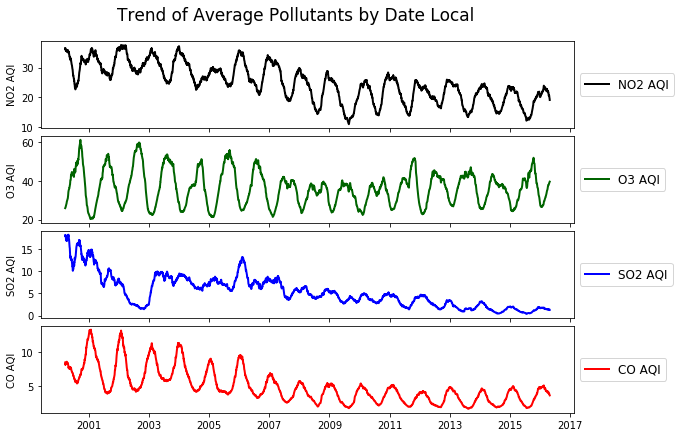

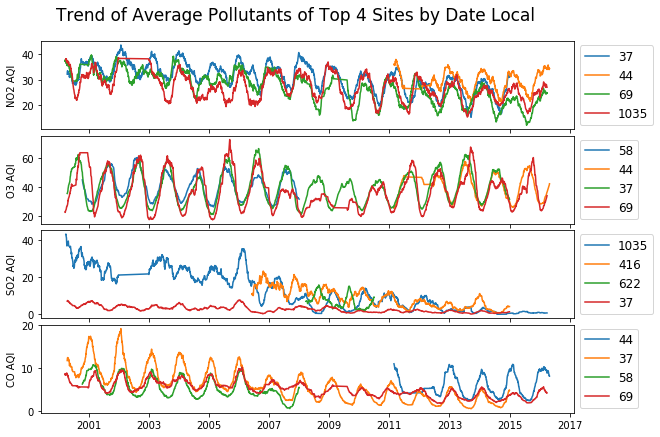

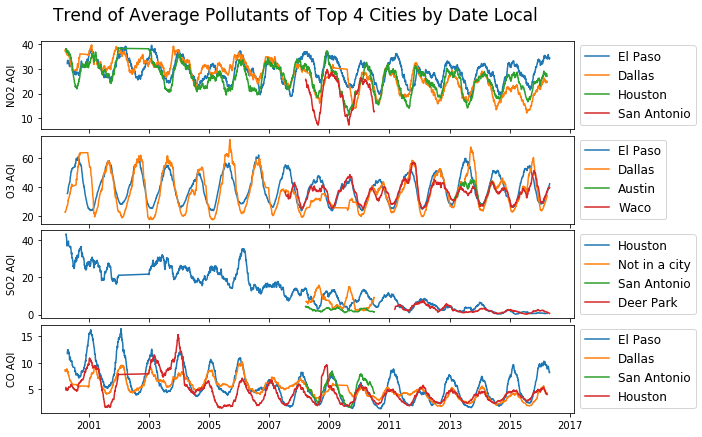

In [46]:
# Only Texas Dataset
texas = df[df.State=="Texas"]

# Temporary NA fix
texas= texas.dropna(axis='rows')

# Missing Values
miss = texas.isnull().sum().reset_index()
miss.columns = ['Column','Missing Count']

# Time Frames of Interest
texas["Date of Year"] = texas['Date Local'].dt.dayofyear # Day of Year
texas["Weekday"] = texas['Date Local'].dt.weekday 

# Input
cols = ["black","darkgreen","blue","red"]
polldata= ['NO2 AQI','O3 AQI','SO2 AQI',"CO AQI"]
# Plotter
def row_plots(data, time, rol_window):
    f, axarr = plt.subplots(len(data), sharex=True, squeeze=True)
    for index, x in enumerate(data):
        plot1 = texas[[x,time]].groupby([time]).mean()
        plot1[x] = plot1[x].rolling(window = rol_window).mean()
        axarr[index].set_ylabel("{}".format(x))
        axarr[index].plot(plot1, color=cols[index],label=x,linewidth=2)
        axarr[index].legend(fontsize='large', loc='center left',
                            bbox_to_anchor=(1, 0.5))
    plt.tight_layout(pad=0)
    plt.subplots_adjust(top=0.90)
    plt.suptitle("Trend of Average Pollutants by {}".format(time),fontsize=17)
    plt.show()

    # 
    site_poll = texas[["Site Num",time,"NO2 AQI","O3 AQI","CO AQI","SO2 AQI"]]\
    .groupby(['Site Num',time]).mean().groupby(level="Site Num")
    
    f, axarr = plt.subplots(len(data), sharex=True, squeeze=True)    
    for index, x in enumerate(data):
        pollutant_plot = site_poll[x]
        pollutant_plotTop = pollutant_plot.mean().nlargest(4).index
        for i in pollutant_plotTop:
            lineplot= pollutant_plot.get_group(i).groupby(pd.Grouper(level=time)).\
            mean().rolling(window = rol_window).mean()
            axarr[index].plot(lineplot)
        axarr[index].legend(pollutant_plotTop,fontsize='large', loc='center left',
                            bbox_to_anchor=(1, 0.5))
        axarr[index].set_ylabel("{}".format(x))  
    plt.tight_layout(pad=0)
    plt.subplots_adjust(top=0.90)
    plt.suptitle("Trend of Average Pollutants of Top 4 Sites by {}".format(time),fontsize=17)
    plt.show()
    plt.show()
    
    # City plots:
    city_poll = texas[["City",time,"NO2 AQI","O3 AQI","CO AQI","SO2 AQI"]]\
    .groupby(['City',time]).mean().groupby(level="City")

    f, axarr = plt.subplots(len(data), sharex=True, squeeze=True)    
    for index, x in enumerate(data):
        pollutant_plot = city_poll[x]
        pollutant_plotTop = pollutant_plot.mean().nlargest(4).index
        for i in pollutant_plotTop:
            lineplot= pollutant_plot.get_group(i).groupby(pd.Grouper(level=time)).mean().rolling(window = rol_window).mean()
            axarr[index].plot(lineplot)
        axarr[index].legend(pollutant_plotTop,fontsize='large', loc='center left',
                            bbox_to_anchor=(1, 0.5))
        axarr[index].set_ylabel("{}".format(x))
        
    plt.tight_layout(pad=0)
    plt.subplots_adjust(top=0.90)
    plt.suptitle("Trend of Average Pollutants of Top 4 Cities by {}".format(time),fontsize=17)
    plt.show()
    plt.show()
    
row_plots(data=polldata, time= "Date Local", rol_window=80)

In [ ]:
'''The Trend Analysis over 16 years of data also supports the fact that there is a declining trend of all the pollutants except Ozone
Cities like El Paso shows increasing trend '''

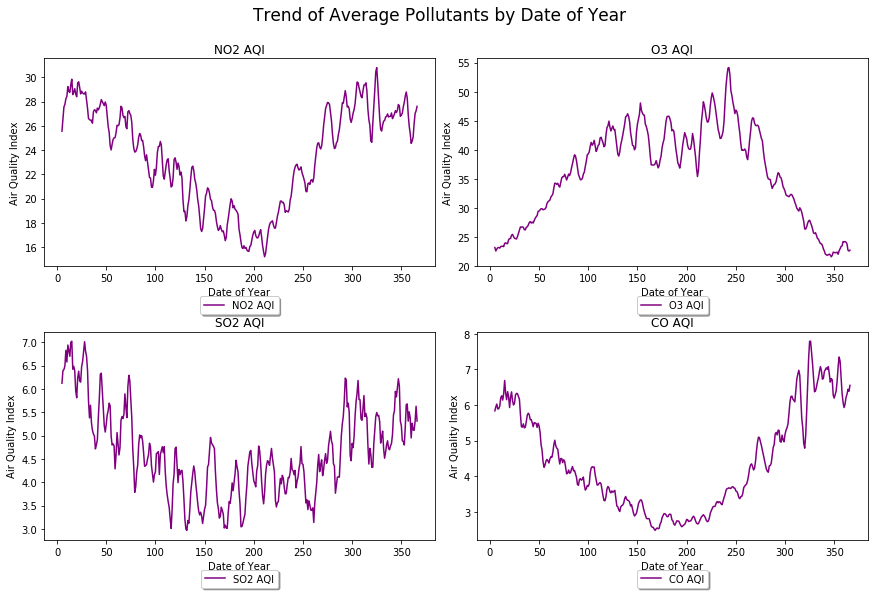

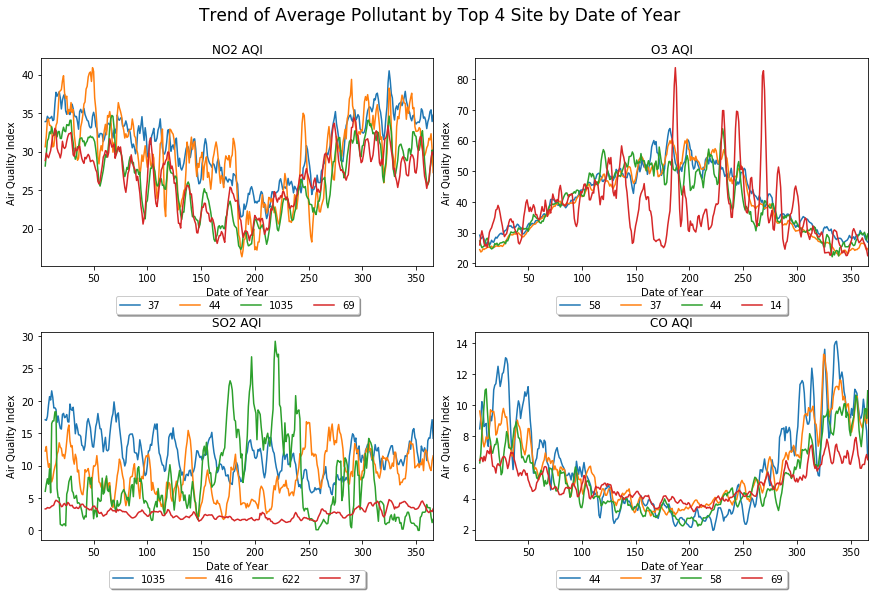

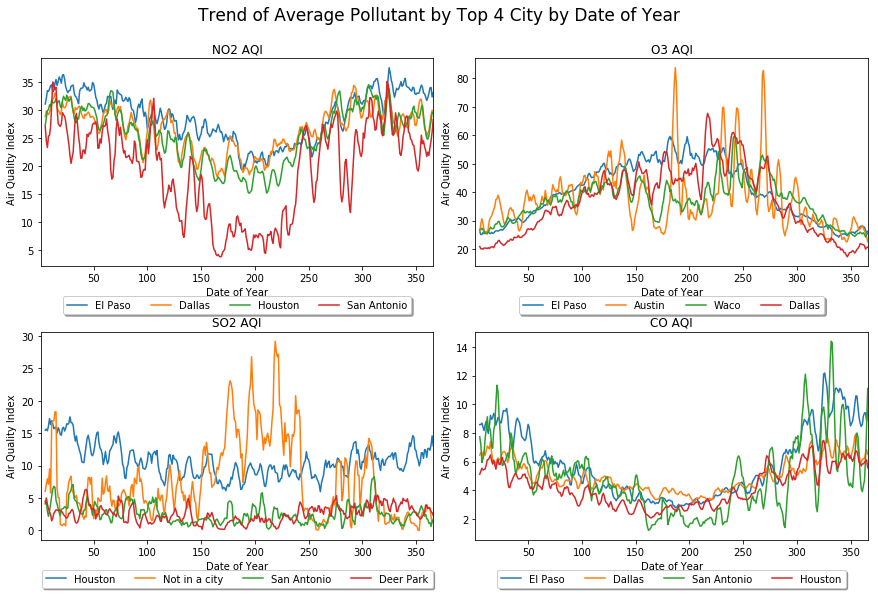

In [47]:
# Plot Mega-Helper
def years_site_city_plot(time, rol_window):
    plt.figure(figsize=(12,8))    
    for var,plot in [('NO2 AQI',221), ('O3 AQI',222),('SO2 AQI',223),("CO AQI",224)]:
        plt.subplot(plot)
        plot1 = texas[[var,time]].groupby([time]).mean()
        plot1[var] = plot1[var].rolling(window = rol_window).mean()
        plt.plot(plot1, color='purple', label=var)
        plt.title(var)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=4)
        plt.title(var)
        plt.xlabel(time)
        plt.ylabel("Air Quality Index")
    plt.tight_layout(pad=0, w_pad=0.5, h_pad=2.5)
    plt.subplots_adjust(top=0.89)
    plt.suptitle("Trend of Average Pollutants by {}".format(time),fontsize=17)
    plt.show()
    
    # Site
    site_poll = texas[["Site Num",time,"NO2 AQI","O3 AQI","CO AQI","SO2 AQI"]]\
    .groupby(['Site Num',time]).mean().groupby(level="Site Num")

    plt.figure(figsize=(12,8))
    for var,plot in [('NO2 AQI',221), ('O3 AQI',222),('SO2 AQI',223),("CO AQI",224)]:
        plt.subplot(plot)
        pollutant_plot = site_poll[var]
        pollutant_plotTop = pollutant_plot.mean().nlargest(4).index
        for i in pollutant_plotTop:
            plot1= pollutant_plot.get_group(i).groupby(pd.Grouper(level=time))\
            .mean().rolling(window = rol_window).mean().plot()
        plt.legend(pollutant_plotTop, loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=4)
        plt.title(var)
        plt.xlabel(time)
        plt.ylabel("Air Quality Index")

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=2.5)
    plt.subplots_adjust(top=0.89)
    plt.suptitle("Trend of Average Pollutant by Top 4 Site by {}".format(time),fontsize=17)
    plt.show()

    # City
    city_poll = texas[["City",time,"NO2 AQI","O3 AQI","CO AQI","SO2 AQI"]]\
    .groupby(['City',time]).mean().groupby(level="City")

    plt.figure(figsize=(12,8))
    for var,plot in [('NO2 AQI',221), ('O3 AQI',222),('SO2 AQI',223),("CO AQI",224)]:
        plt.subplot(plot)
        pollutant_plot = city_poll[var]
        pollutant_plotTop = pollutant_plot.mean().nlargest(4).index
        for i in pollutant_plotTop:
            plot1= pollutant_plot.get_group(i).groupby(pd.Grouper(level=time))\
            .mean().rolling(window = rol_window).mean().plot()
        plt.title(var)
        plt.xlabel(time)
        plt.ylabel("Air Quality Index")
        plt.legend(pollutant_plotTop, loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=4)

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=2.5)
    plt.subplots_adjust(top=0.89)
    plt.suptitle("Trend of Average Pollutant by Top 4 City by {}".format(time),fontsize=17)
    plt.savefig('Trend of Average Pollutant by Top 4 City.png')
    plt.show()

years_site_city_plot(time="Date of Year", rol_window=5)

In [ ]:
'''The Trend by Date of Year clearly shows Seasonality which means that weather/seasons play a role in AQI levels '''

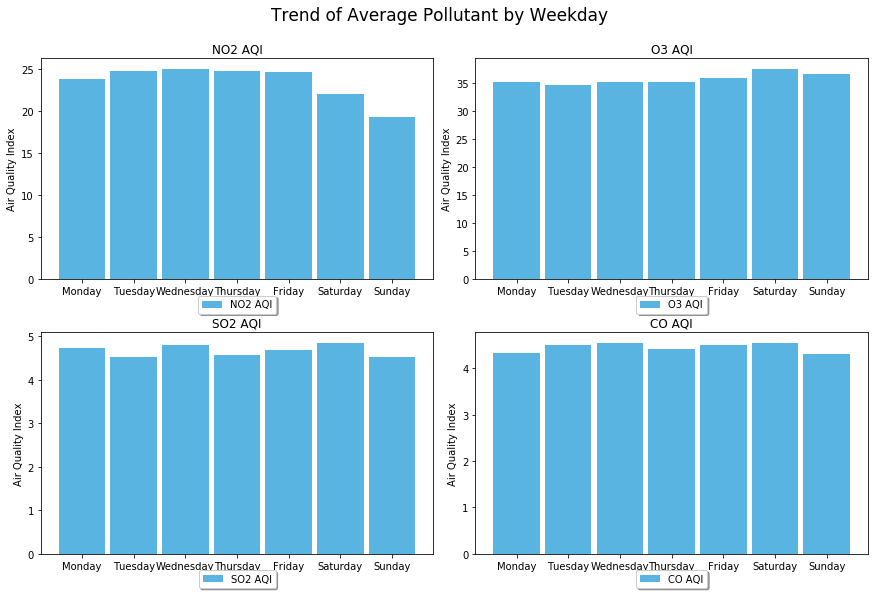

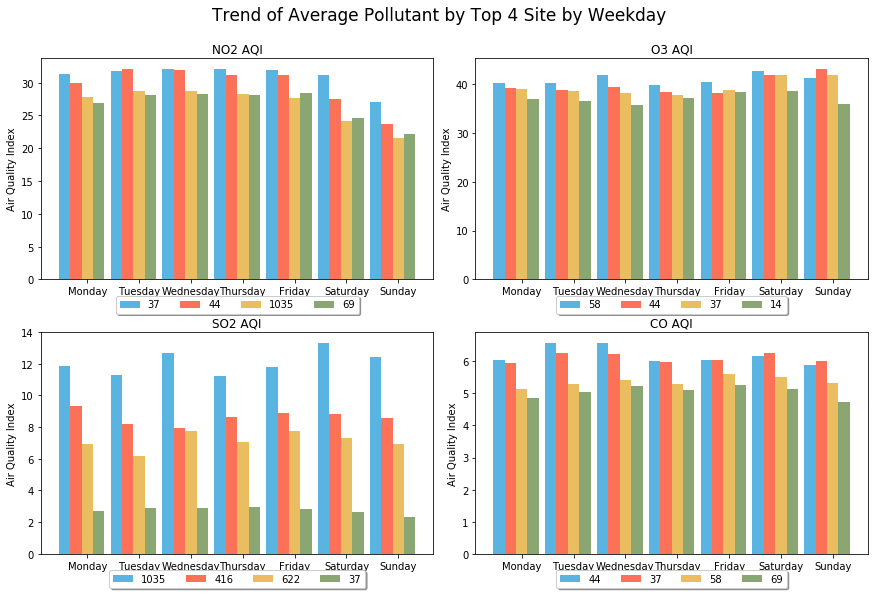

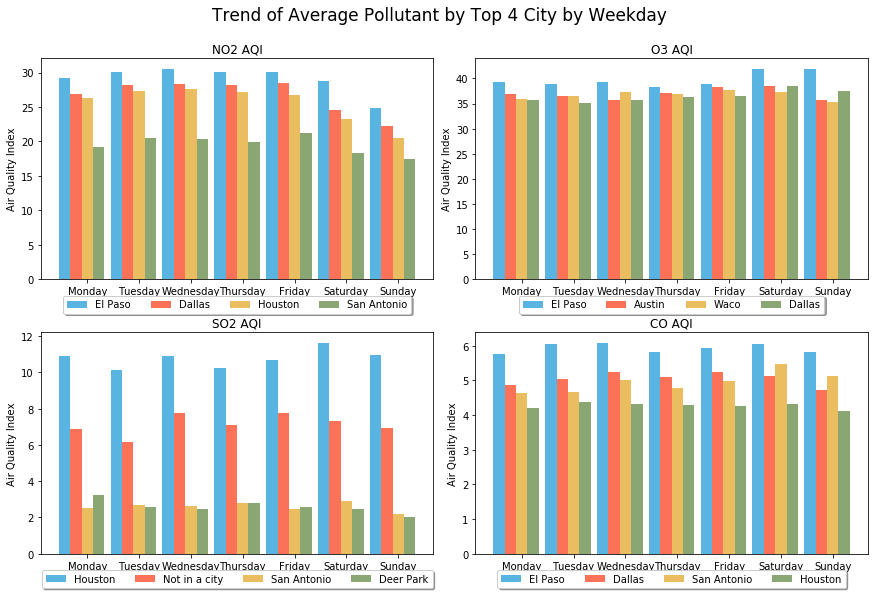

In [48]:
a = 0.80
def pol_bar_plot(time, rol_window):
    plt.figure(figsize=(12,8))
    width = .90 
    plot1 = texas.groupby([time]).mean()
    plot1 = plot1.rolling(window = rol_window).mean()
    X= list(range(len(set(plot1.index))))
    labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    
    for index, (var,plot) in enumerate([('NO2 AQI',221), ('O3 AQI',222),('SO2 AQI',223),("CO AQI",224)]):
        plt.subplot(plot)
        X= list(range(len(set(plot1.index))))
        plt.bar(left=[p + width for p in X], height=plot1[var],
                width=width,label=var,alpha=a)
        plt.title(var)
        # plt.xlabel(time)
        plt.ylabel("Air Quality Index")
        plt.xticks([p + width for p in X], labels)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                   fancybox=True, shadow=True, ncol=4)
    plt.tight_layout(pad=0, w_pad=0.5, h_pad=2.5)
    plt.subplots_adjust(top=0.89)
    plt.suptitle("Trend of Average Pollutant by {}".format(time),fontsize=17)
    plt.show()
    
    # Site
    site_poll = texas[["Site Num",time,"NO2 AQI","O3 AQI","CO AQI","SO2 AQI"]]\
    .groupby(['Site Num',time]).mean().groupby(level="Site Num")
    width = .22
    plt.figure(figsize=(12,8))
    for index, (var,plot) in enumerate([('NO2 AQI',221), ('O3 AQI',222),('SO2 AQI',223),("CO AQI",224)]):
        plt.subplot(plot)
        pollutant_plot = site_poll[var]
        pollutant_plotTop = pollutant_plot.mean().nlargest(4).index
        for index, i in enumerate(pollutant_plotTop):
            plot1= pollutant_plot.get_group(i).groupby(pd.Grouper(level=time))\
            .mean().rolling(window = rol_window).mean()
            plt.bar(left=[p + width*index for p in X], height=plot1,width=width, label=i,alpha=a)   
        plt.title(var)
        # plt.xlabel(time)
        plt.ylabel("Air Quality Index")
        plt.xticks([p + (width*len(pollutant_plotTop))/2 for p in X], labels)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
    plt.tight_layout(pad=0, w_pad=0.5, h_pad=2.5)
    plt.subplots_adjust(top=0.89)
    plt.suptitle("Trend of Average Pollutant by Top 4 Site by {}".format(time),fontsize=17)
    plt.show()
    
   # City
    city_poll = texas[["City",time,"NO2 AQI","O3 AQI","CO AQI","SO2 AQI"]]\
    .groupby(['City',time]).mean().groupby(level="City")

    width = .22
    
    plt.figure(figsize=(12,8))
    for index, (var,plot) in enumerate([('NO2 AQI',221), ('O3 AQI',222),('SO2 AQI',223),("CO AQI",224)]):
        plt.subplot(plot)
        pollutant_plot = city_poll[var]
        pollutant_plotTop = pollutant_plot.mean().nlargest(4).index
        for index, i in enumerate(pollutant_plotTop):
            plot1= pollutant_plot.get_group(i).groupby(pd.Grouper(level=time))\
            .mean().rolling(window = rol_window).mean()
            plt.bar(left=[p + width*index for p in X], height=plot1,width=width, label=i,alpha=a)   
        plt.title(var)
        # plt.xlabel(time)
        plt.ylabel("Air Quality Index")
        plt.xticks([p + (width*len(pollutant_plotTop))/2 for p in X], labels)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=2.5)
    plt.subplots_adjust(top=0.89)
    plt.suptitle("Trend of Average Pollutant by Top 4 City by {}".format(time),fontsize=17)
    plt.show()

# New Color Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])    
# Plot Data
pol_bar_plot(time="Weekday", rol_window=1)

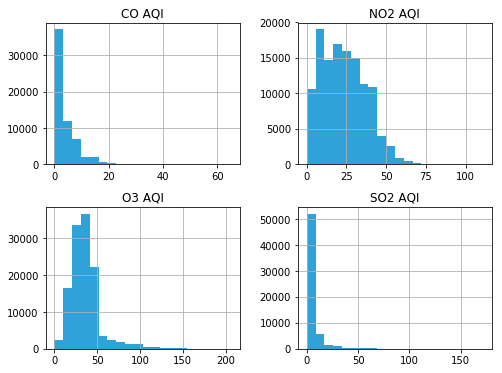

Unique Sites: 11
Unique Cities: 8
Unique Counties: 6


In [49]:
Pollutants = cal[["NO2 AQI","O3 AQI","SO2 AQI", "CO AQI"]]
Pollutants.index = cal["Date Local"]

# Exclude Outliers
Pollutants.hist(bins=20)
plt.show()

print("Unique Sites:",len(cal["Site Num"].unique()))
print("Unique Cities:",len(cal["City"].unique()))
print("Unique Counties:",len(cal["County"].unique()))


In [ ]:
'''CO and SO2 seem to have more extreme outliers. 
We will correlate all the pollutants and identify which has higher degree of correlation'''

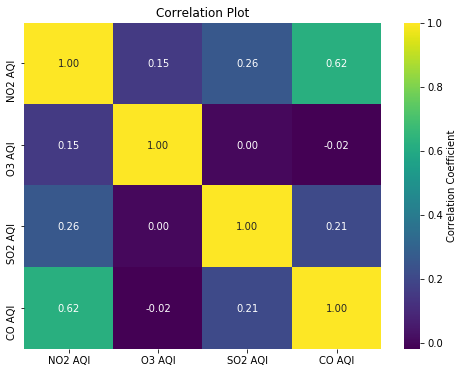

In [50]:
sns.heatmap(Pollutants.corr(), annot=True, fmt=".2f", cmap="viridis",cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Plot")
plt.show()


In [ ]:
'''Interpretation:
CO AQI and NO2 AQI stand out with the highest positive correlation out of the bunch.'''

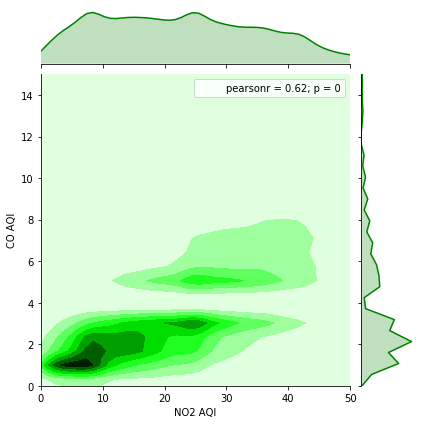

In [51]:
# Examine Strongest Correlation
sns.jointplot(x=cal["NO2 AQI"], y=cal["CO AQI"], kind='kde', xlim=(0,50),ylim=(0,15),color='g')
plt.show()

In [ ]:
'''
Increase NO2 affects rise in CO2 but at not at a steady rate
'''